In [ ]:
import numpy as np
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
load_path = '/content/drive/My Drive/'
Reconstructed_sigma1 = np.load(load_path + 'Reconstructed_sigma1.npy')
Reconstructed_sigma2 = np.load(load_path + 'Reconstructed_sigma2.npy')
Reconstructed_sigma3 = np.load(load_path + 'Reconstructed_sigma3.npy')

tumor_masks = np.load(load_path + 'tumor_masks.npy')


In [ ]:

Reconstructed_sigma1 = Reconstructed_sigma1.reshape(40, 128, 128, 1)
Reconstructed_sigma2 = Reconstructed_sigma2.reshape(40, 128, 128, 1)
Reconstructed_sigma3 = Reconstructed_sigma3.reshape(40, 128, 128, 1)

#Resnet-18

In [ ]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

#Unet+Resnet Segmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Concatenate, Conv2DTranspose, Input
from tensorflow.keras.models import Model

# ResNet18 Block Definition
class ResnetBlock(Model):
    def __init__(self, channels: int, down_sample=False):
        super().__init__()
        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Concatenate()

        if self.__down_sample:
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

# ResNet18 Encoder Definition
class ResNet18_Encoder(Model):
    def __init__(self):
        super(ResNet18_Encoder, self).__init__()
        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)

    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.init_bn(x)
        x = tf.nn.relu(x)
        x = self.pool_2(x)

        skip1 = self.res_1_1(x)
        skip2 = self.res_2_1(skip1)
        skip3 = self.res_3_1(skip2)
        skip4 = self.res_4_1(skip3)

        return skip1, skip2, skip3, skip4

# Decoder Block Definition
def decoder_block(x, skip, filters):
    x = Conv2DTranspose(filters, kernel_size=(2, 2), strides=2, padding="same")(x)
    skip = Conv2DTranspose(filters, kernel_size=(2, 2), strides=2, padding="same")(skip)
    x = Concatenate()([x, skip])
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def final_upsample_block(x, filters=64, num_classes=2):
    # Upsample using transpose convolution
    x = Conv2DTranspose(filters, kernel_size=(2, 2), strides=2, padding="same")(x)


    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Final 1x1 convolution to produce the desired number of output channels (num_classes)
    x = Conv2D(num_classes, (1, 1), activation="sigmoid" if num_classes == 1 else "softmax")(x)

    return x

# U-Net with ResNet18 Encoder
def build_unet_resnet18(input_shape=(128, 128, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Encoder with ResNet18
    encoder = ResNet18_Encoder()
    skip1, skip2, skip3, skip4 = encoder(inputs)

    # Decoder path
    d1 = decoder_block(skip4, skip4, 512)
    d2 = decoder_block(d1, skip3, 256)
    d3 = decoder_block(d2, skip2, 128)
    d4 = decoder_block(d3, skip1, 64)

    # Final output block with upsampling and output layer
    outputs = final_upsample_block(d4, filters=64, num_classes=num_classes)

    # Construct and return the model
    model = Model(inputs, outputs)
    return model

# Compile the model
model = build_unet_resnet18()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'res_net18__encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


# Segmentation of 1st Reconstruction

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.6125 - loss: 0.7012 - val_accuracy: 0.6808 - val_loss: 0.6833
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8137 - loss: 0.5977 - val_accuracy: 0.8429 - val_loss: 0.6522
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9614 - loss: 0.5209 - val_accuracy: 0.9608 - val_loss: 0.5491
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9817 - loss: 0.4638 - val_accuracy: 0.9875 - val_loss: 0.4057
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9876 - loss: 0.4162 - val_accuracy: 0.9891 - val_loss: 0.2757
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9891 - loss: 0.3752 - val_accuracy: 0.9901 - val_loss: 0.1875
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9889 - loss: 0.3400 - val_accuracy: 0.9901 - val_loss: 0.1429
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9895 - loss: 0.3076 - val_accuracy: 0.9901 - val_loss: 0

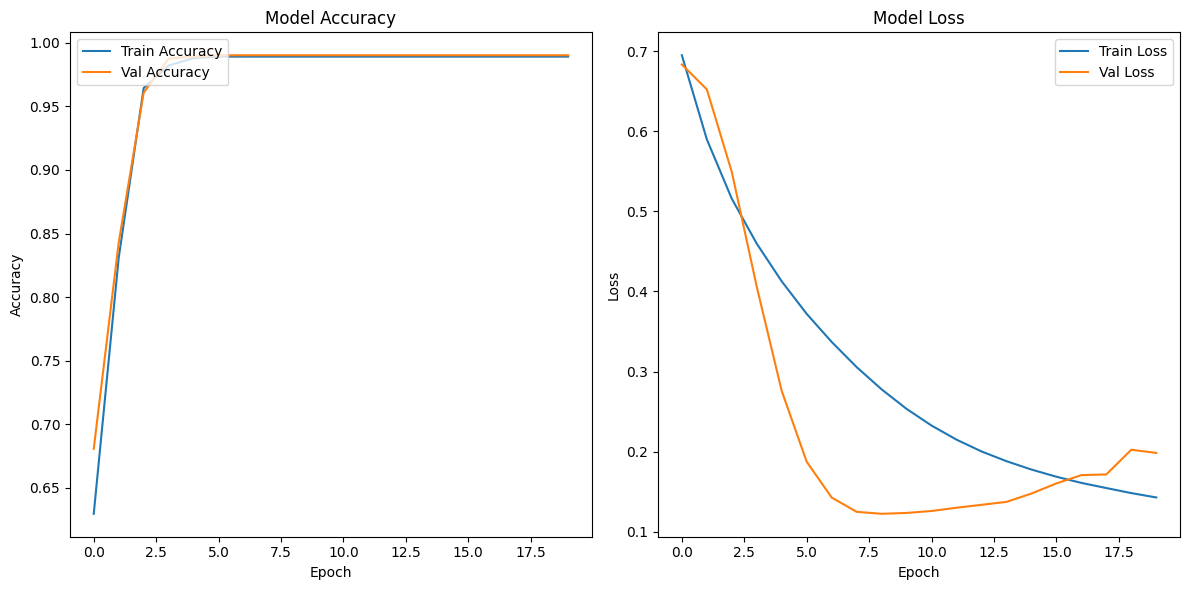

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(Reconstructed_sigma1, tumor_masks, test_size=0.2, random_state=42)


y_train = tf.keras.utils.to_categorical(y_train, num_classes=2) #one hot
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16
)


plt.figure(figsize=(12, 6))

#accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

#loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()



#Segmentation of 2nd reconstruction

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9893 - loss: 0.1415 - val_accuracy: 0.9901 - val_loss: 0.2525
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9891 - loss: 0.1360 - val_accuracy: 0.9901 - val_loss: 0.2573
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9889 - loss: 0.1324 - val_accuracy: 0.9901 - val_loss: 0.2387
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9885 - loss: 0.1291 - val_accuracy: 0.9901 - val_loss: 0.1970
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9893 - loss: 0.1238 - val_accuracy: 0.9901 - val_loss: 0.1707
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9891 - loss: 0.1210 - val_accuracy: 0.9901 - val_loss: 0.1522
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9890 - loss: 0.1182 - val_accuracy: 0.9901 - val_loss: 0.1370
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9894 - loss: 0.1145 - val_accuracy: 0.9901 - val_loss:

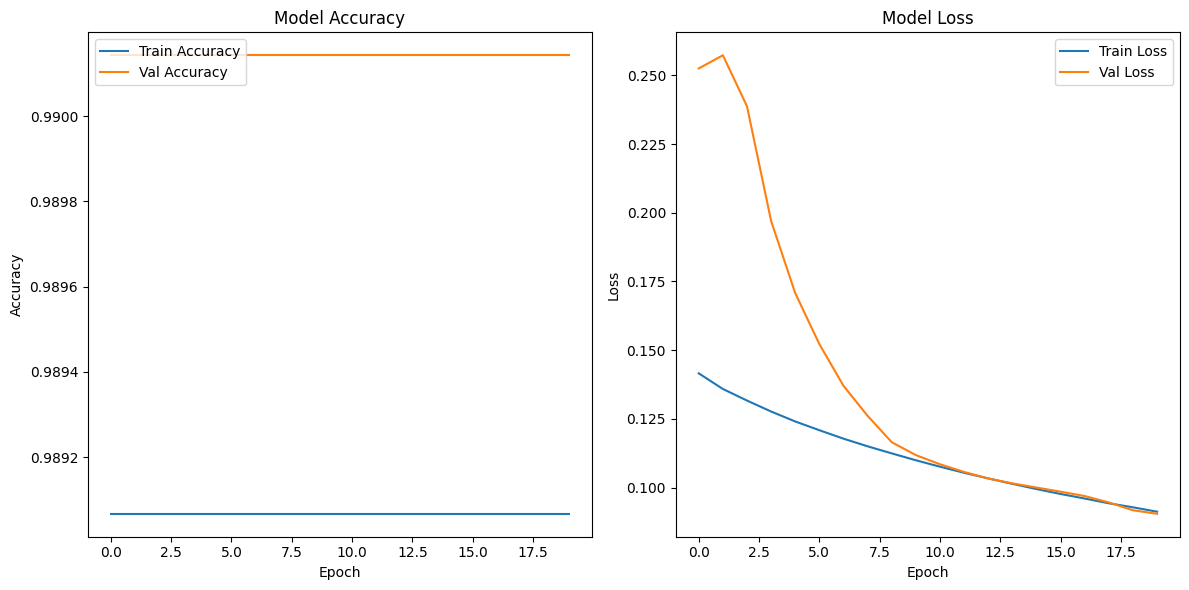

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(Reconstructed_sigma2, tumor_masks, test_size=0.2, random_state=42)


y_train = tf.keras.utils.to_categorical(y_train, num_classes=2) #one hot
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16
)


plt.figure(figsize=(12, 6))

#accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

#loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()



#Segmentation of 3rd Reconstruction

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9888 - loss: 0.0915 - val_accuracy: 0.9901 - val_loss: 0.0873
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9890 - loss: 0.0894 - val_accuracy: 0.9901 - val_loss: 0.0846
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9890 - loss: 0.0873 - val_accuracy: 0.9901 - val_loss: 0.0806
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9890 - loss: 0.0861 - val_accuracy: 0.9901 - val_loss: 0.0801
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9892 - loss: 0.0843 - val_accuracy: 0.9901 - val_loss: 0.0820
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9890 - loss: 0.0829 - val_accuracy: 0.9901 - val_loss: 0.0794
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9886 - loss: 0.0829 - val_accuracy: 0.9901 - val_loss: 0.0789
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9890 - loss: 0.0805 - val_accuracy: 0.9901 - val_loss:

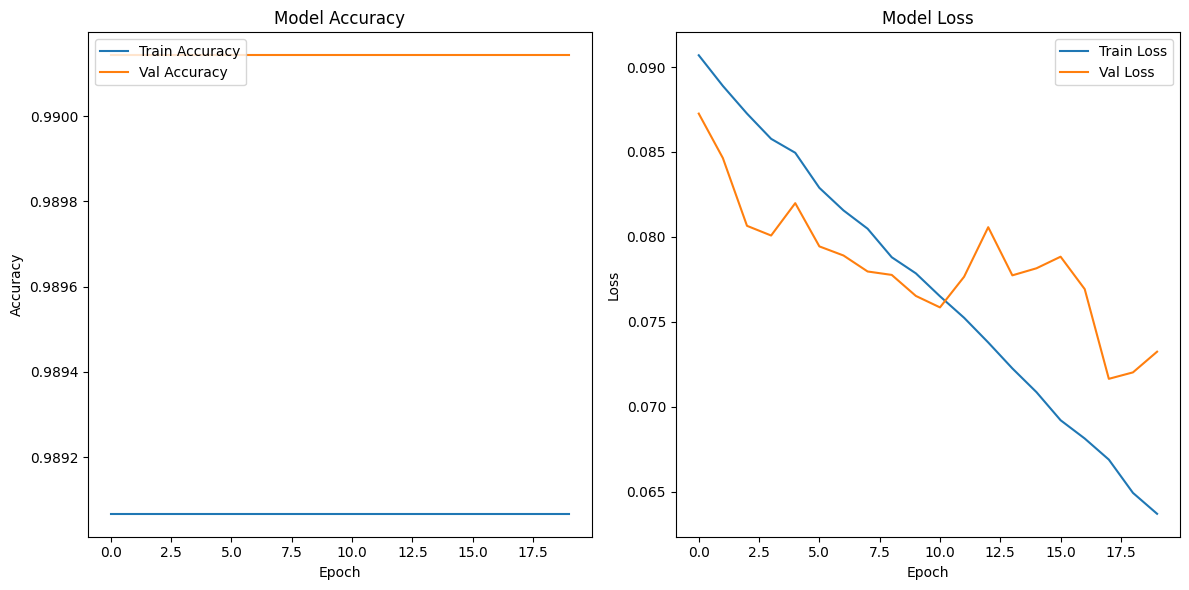

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(Reconstructed_sigma3, tumor_masks, test_size=0.2, random_state=42)


y_train = tf.keras.utils.to_categorical(y_train, num_classes=2) #one hot
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16
)


plt.figure(figsize=(12, 6))

#accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

#loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()

